# HOW IS GENDER DISTRIBUTED ON EPFL CAMPUS AND CAN WE PREDICT IT ?
NTDS 2019 project main file
* Team: 1
* Students: Magnin Jonathan, Nonaca Darja, Shmeis Zeinab, Wang Shu

## LICENSE
### YOLO LICENSE
Version 2, July 29 2016

THIS SOFTWARE LICENSE IS PROVIDED "ALL CAPS" SO THAT YOU KNOW IT IS SUPER
SERIOUS AND YOU DON'T MESS AROUND WITH COPYRIGHT LAW BECAUSE YOU WILL GET IN
TROUBLE HERE ARE SOME OTHER BUZZWORDS COMMONLY IN THESE THINGS WARRANTIES
LIABILITY CONTRACT TORT LIABLE CLAIMS RESTRICTION MERCHANTABILITY. NOW HERE'S
THE REAL LICENSE:

0. Darknet is public domain.
1. Do whatever you want with it.
2. Stop emailing me about it!

## DESCRIPTION
This notebook contains all the code of our project. It is structured in the following way :

* Data Aquisition and Formatting
* Data Processing
* Data Exploration
    * Dimensionality reduction
    * Graph creation and visualization
* Prediction


## 0. Packages

In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import networkx as nx

## 1. Data Aquisition and Formatting
Most of the data aquisition is done in the create_dataset.ipynb file, that cannot be executed because private data are not uploaded.
The result of this code is in the Dataset folder, we simply load it.

In [2]:
# load dataset
complete_data = pd.read_csv("../Dataset/complete_data.csv")
complete_test_data = pd.read_csv("../Dataset/complete_test_data.csv")

# have a look at the data
complete_data

,Unnamed: 0,course,course_sct,prof,sct_student,year,gender,nationality,student_id
0,0,1st Workshop on Advances in CFD and MD modelli...,Energie (edoc),"Thome John Richard, Magnini Mirco, Various lec...","Mécanique (edoc), EDOC",2016-2017,Monsieur,suisse,27667
1,1,Similarity and Transport Phenomena in Fluid,Mécanique (edoc),Ancey Christophe,"Mécanique (edoc), EDOC",2016-2017,Monsieur,suisse,27667
2,4,1st Workshop on Advances in CFD and MD modelli...,Energie (edoc),"Thome John Richard, Magnini Mirco, Various lec...","Energie (edoc), EDOC",2016-2017,Monsieur,allemande,46270
3,6,"2D Layered Materials: Synthesis, Properties an...",Science et génie des matériaux (edoc),Kis Andras,"Auditeurs EDOC, 2016-2017",2016-2017,Monsieur,suisse,21602
4,8,"2D Layered Materials: Synthesis, Properties an...",Science et génie des matériaux (edoc),Kis Andras,"Physique (edoc), EDOC",2016-2017,Monsieur,française,48264
...,...,...,...,...,...,...,...,...,...
227482,229274,Théorie et critique du projet MA1 (Födinger),Mobilité AR,Födinger Karsten,NaN,"2019-2020, Semestre automne",Monsieur,allemande,67309
227483,229275,UE A: Art and architecture,Mobilité AR,Weber Christoph,NaN,"2019-2020, Semestre automne",Monsieur,allemande,67309
227484,229276,Théorie et critique du projet MA1 (Weinand),Mobilité AR,Weinand Yves,NaN,"2019-2020, Semestre automne",Madame,allemande,67287
227485,229277,UE K : Architecture et durabilité : études de ...,Mobilité AR,"Rey Emmanuel, Fivet Corentin Jean Dominique, F...",NaN,"2019-2020, Semestre automne",Madame,allemande,67287


## 2. Data Processing

### Sorting
The goal of this section is to extract the features, which are the courses that each students subscribes to.
In these data, we do not want to use everything.
We work with master students and courses because includoing bachelor students has three problems :

* It lower the prediction accuracy due to the large amount of common courses
* It deteriorates the quality of visualization
* It does not makes much sense to include it since there is no or little choice in bachelor courses and we base our prediction on this choice

Thus, we only use data from master students.

In [3]:
# identify bachelor and master students
year = complete_data['year']
ma =['Master' in s for s in year]
ba = ['Bachelor' in s for s in year]
pd_master = complete_data[ma]
pd_bachelor = complete_data[ba]

In [4]:
print(f"Number of Master students: {len(pd_master['student_id'].unique())}")
print(f"Number of Bachelor students: {len(pd_bachelor['student_id'].unique())}")

Number of Master students: 6530
Number of Bachelor students: 10464


In [5]:
print(f"Number of Master courses: {len(pd_master['course'].unique())}")
print(f"Number of Bachelor courses: {len(pd_bachelor['course'].unique())}")

Number of Master courses: 966
Number of Bachelor courses: 755


In [6]:
course_count = pd_master['course'].value_counts()
course_count

Machine learning                                      846
Applied data analysis                                 756
Management de projet et analyse du risque             651
Image processing I                                    598
Applied machine learning                              533
                                                     ... 
Stages semestriels                                      1
Projet de master en science et génie des matériaux      1
Didactique des mathématiques                            1
Projet de master en ingénierie financière               1
Evaluations des apprentissages                          1
Name: course, Length: 966, dtype: int64

In [7]:
stud_ids = pd_master["student_id"].unique()
courses = pd_master['course'].unique()
n_stud = len(stud_ids)
n_c = len(courses)
student_course_matrix = np.empty((n_stud, n_c))

In [8]:
# creating the  student_course_matrix
for idx, row in pd_master.iterrows():
    l = np.where(row["student_id"] == stud_ids)
    c = np.where(courses == row["course"])
    student_course_matrix[l[0][0]][c[0][0]] = 1

We can now also remove bachelor students from the test data.

In [9]:
# isolate master students master students
year = complete_test_data['year']
ma =['Master' in s for s in year]
pd_master_test = complete_test_data[ma]
stud_ids_test = pd_master_test["student_id"].unique()
courses = pd_master_test['course'].unique()

n_stud = stud_ids_test.shape[0]
n_c = courses.shape[0]
student_course_matrix_test = np.empty((n_stud, n_c))
for idx, row in pd_master_test.iterrows():
    l = np.where(row["student_id"] == stud_ids_test)
    c = np.where(courses == row["course"])
    student_course_matrix_test[l[0][0]][c[0][0]] = 1

Finaly, let us have a look at the feature matrices :

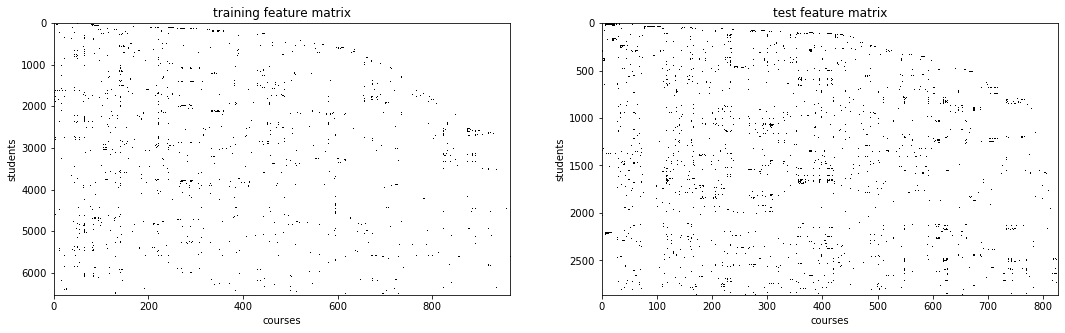

In [10]:
# plot feature matrices

fig = plt.figure(figsize=(18,5))

plt.subplot(121)
plt.xlabel('courses')
plt.ylabel('students')
plt.title('training feature matrix')
plt.imshow(student_course_matrix, aspect='auto', cmap='binary')

plt.subplot(122)
plt.xlabel('courses')
plt.ylabel('students')
plt.title('test feature matrix')
plt.imshow(student_course_matrix_test, aspect='auto', cmap='binary')

### Labeling
The goal of this section is to create labels for visualization and prediction. We will use the following labels :
* Sections
* Faculties
* Gender

In [11]:
# section labels for training data
sections = pd_master['sct_student'].unique()
new_sections = np.ndarray(0)

# remove unwanted info (year/semester)
for line in sections :
    if type(line) is str :
        new_line = line.split(",")[0]
        new_sections = np.append(new_sections, new_line)

# create the section list with an "other" section for undefined fields of the dataset
new_sections = np.append(new_sections, ["other"])
sections = np.unique(new_sections)
print("All sections :")
for i,s in enumerate(sections) :
    print((str)(i) + " : " + s)
    
# create (numeric) labels, the labels will be the index of the section in the array above
students_sct_label = np.ndarray(stud_ids.shape)
for i in range(0,stud_ids.shape[0]) :
    # get section of student
    id = stud_ids[i]
    sct = complete_data.loc[complete_data["student_id"] == id, "sct_student"] # will return EVERY entry of student's section : can sometimes be NaN !!!
    for elem in sct :
        if type(elem) is str :
            sct = elem
            break
    
    # if there are only NaN
    if type(sct) is not str :
        sct = "other"
    
    # find the good label
    for j in range(0, sections.shape[0]) :
        if (sct.find(sections[j]) != -1) :
            students_sct_label[i] = (int)(j)
            break

# gender labels for training data
students_gender = list()
for i in range(0, stud_ids.shape[0]) :
    id = stud_ids[i]
    gender = (str)(complete_data.loc[complete_data["student_id"] == id, "gender"])
    if gender.find("Monsieur") != -1 :
        gender = 1
    else :
        gender = 0
    students_gender.append(gender)

# gender labels for test data
students_gender_test = list()
for i in range(0, stud_ids_test.shape[0]) :
    id = stud_ids_test[i]
    gender = (str)(complete_test_data.loc[complete_test_data["student_id"] == id, "gender"])
    if gender.find("Monsieur") != -1 :
        gender = 1
    else :
        gender = 0
    students_gender_test.append(gender)

All sections :
0 : Approches moléculaires du vivant (edoc)
1 : Architecture
2 : Architecture et sciences de la ville (edoc)
3 : Auditeurs libres
4 : Bioingénierie
5 : Biologie computationnelle et quantitative (edoc)
6 : Biotechnologie et génie biologique (edoc)
7 : Chimie et génie chimique
8 : Chimie et génie chimique (edoc)
9 : Chimie moléculaire et biologique
10 : Data Science
11 : Energie (edoc)
12 : Energy Science and Technology
13 : Gestion de l'énergie et durabilité
14 : Génie chimique et biotechnologie
15 : Génie civil
16 : Génie civil et environnement (edoc)
17 : Génie mécanique
18 : Génie nucléaire
19 : Génie électrique (edoc)
20 : Génie électrique et électronique 
21 : Humanités digitales
22 : Informatique
23 : Informatique - Cybersecurity
24 : Informatique et communications (edoc)
25 : Ingénierie des sciences du vivant
26 : Ingénierie financière
27 : Ingénierie mathématique
28 : Ingénierie physique
29 : Management
30 : Management de la technologie (edoc)
31 : Manufacturing (

We can see that there are many, many sections. This is mostly due to exchanges, external students, "auditeurs libres",... Thus, to have less labels, we use the "real" sections, for instance, an exchange student in EL is indeed in the EL section. We also regroup the sections in their faculties to have an even smaller amount of labels, but this might be slightly gross.

In [12]:
# create an array that makes sections correspond to faculties
sct_to_fac = list()

for i in range(0, sections.shape[0]) :
    sct_to_fac.append("")

sct_to_fac[0] = "SV"
sct_to_fac[1] = "ENAC"
sct_to_fac[2] = "ENAC"
sct_to_fac[3] = "other"
sct_to_fac[4] = "STI"
sct_to_fac[5] = "SV"
sct_to_fac[6] = "SV"
sct_to_fac[7] = "SB"
sct_to_fac[8] = "SB"
sct_to_fac[9] = "SB"
sct_to_fac[10] = "IC"
sct_to_fac[11] = "STI"
sct_to_fac[12] = "STI"
sct_to_fac[13] = "STI"
sct_to_fac[14] = "SB"
sct_to_fac[15] = "ENAC"
sct_to_fac[16] = "ENAC"
sct_to_fac[17] = "STI"
sct_to_fac[18] = "SB"
sct_to_fac[19] = "STI"
sct_to_fac[20] = "STI"
sct_to_fac[21] = "CDH"
sct_to_fac[22] = "IC"
sct_to_fac[23] = "IC"
sct_to_fac[24] = "IC"
sct_to_fac[25] = "SV"
sct_to_fac[26] = "CDM"
sct_to_fac[27] = "SB"
sct_to_fac[28] = "SB"
sct_to_fac[29] = "CDM"
sct_to_fac[30] = "CDM"
sct_to_fac[31] = "STI"
sct_to_fac[32] = "SB"
sct_to_fac[33] = "SB"
sct_to_fac[34] = "SB"
sct_to_fac[35] = "SB"
sct_to_fac[36] = "STI"
sct_to_fac[37] = "STI"
sct_to_fac[38] = "STI"
sct_to_fac[39] = "ENAC"
sct_to_fac[40] = "SB"
sct_to_fac[41] = "STI"
sct_to_fac[42] = "ENAC"
sct_to_fac[43] = "STI"
sct_to_fac[44] = "CDM"
sct_to_fac[45] = "IC"
sct_to_fac[46] = "SB"
sct_to_fac[47] = "STI"
sct_to_fac[48] = "CDM"
sct_to_fac[49] = "STI"
sct_to_fac[50] = "SB"
sct_to_fac[51] = "IC"
sct_to_fac[52] = "ENAC"
sct_to_fac[53] = "SV"
sct_to_fac[54] = "STI"
sct_to_fac[55] = "SV"
sct_to_fac[56] = "STI"
sct_to_fac[57] = "STI"
sct_to_fac[58] = "SB"
sct_to_fac[59] = "SB"
sct_to_fac[60] = "SB"
sct_to_fac[61] = "STI"
sct_to_fac[62] = "STI"
sct_to_fac[63] = "STI"
sct_to_fac[64] = "SB"
sct_to_fac[65] = "ENAC"
sct_to_fac[66] = "SV"
sct_to_fac[67] = "IC"
sct_to_fac[68] = "other"
sct_to_fac[69] = "other"
sct_to_fac[70] = "other"
sct_to_fac[71] = "other"
sct_to_fac[72] = "other"

# create  alist of all faculties
fac_list = ['ENAC', 'IC', 'SB', 'STI', 'SV', 'CDH', 'CDM', 'other']

In [13]:
# label the students with faculties
students_fac = list()
for i in range(0, stud_ids.shape[0]) :
    id = stud_ids[i]
    fac = sct_to_fac[(int)(students_sct_label[i])]
    students_fac.append(fac)

## 3. Data Exploration

### 3.1. Dimensionality Reduction
The students live in the "course space", which has a very high dimension and is thus not observable. Dimensionality reduction will allow to observe it.
After several tests, we concluded that the best reduction is : t-SNE in 2D. Indeed, linear methods are completely unable to show proper clusters, and most non-linear methods suffers from the crowding problem, which t-SNE takes into account.

In [14]:
# dim. reduction of the training data
TSNE_embedding = TSNE(n_components=2)
stu_TSNE_2d = TSNE_embedding.fit_transform(student_course_matrix)

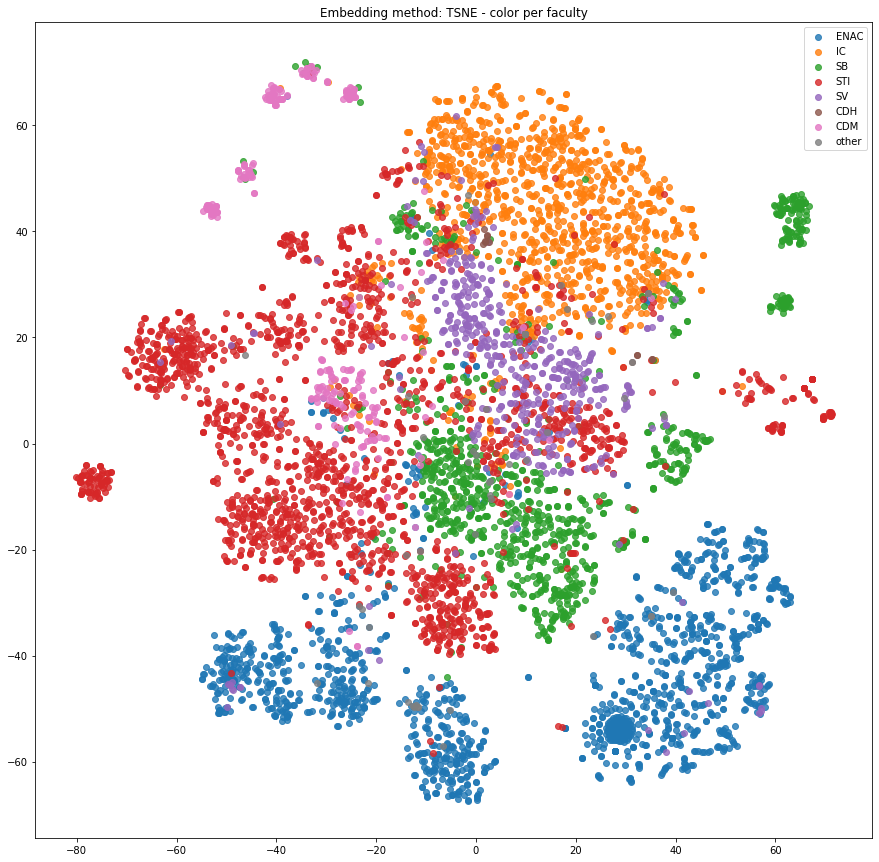

In [15]:
# plot reduced students with faculty labels
fig = plt.figure(figsize=(15,15))

for f in fac_list :
    students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == f], :]
    plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8)


plt.title('Embedding method: TSNE - color per faculty')
plt.legend()
plt.show()

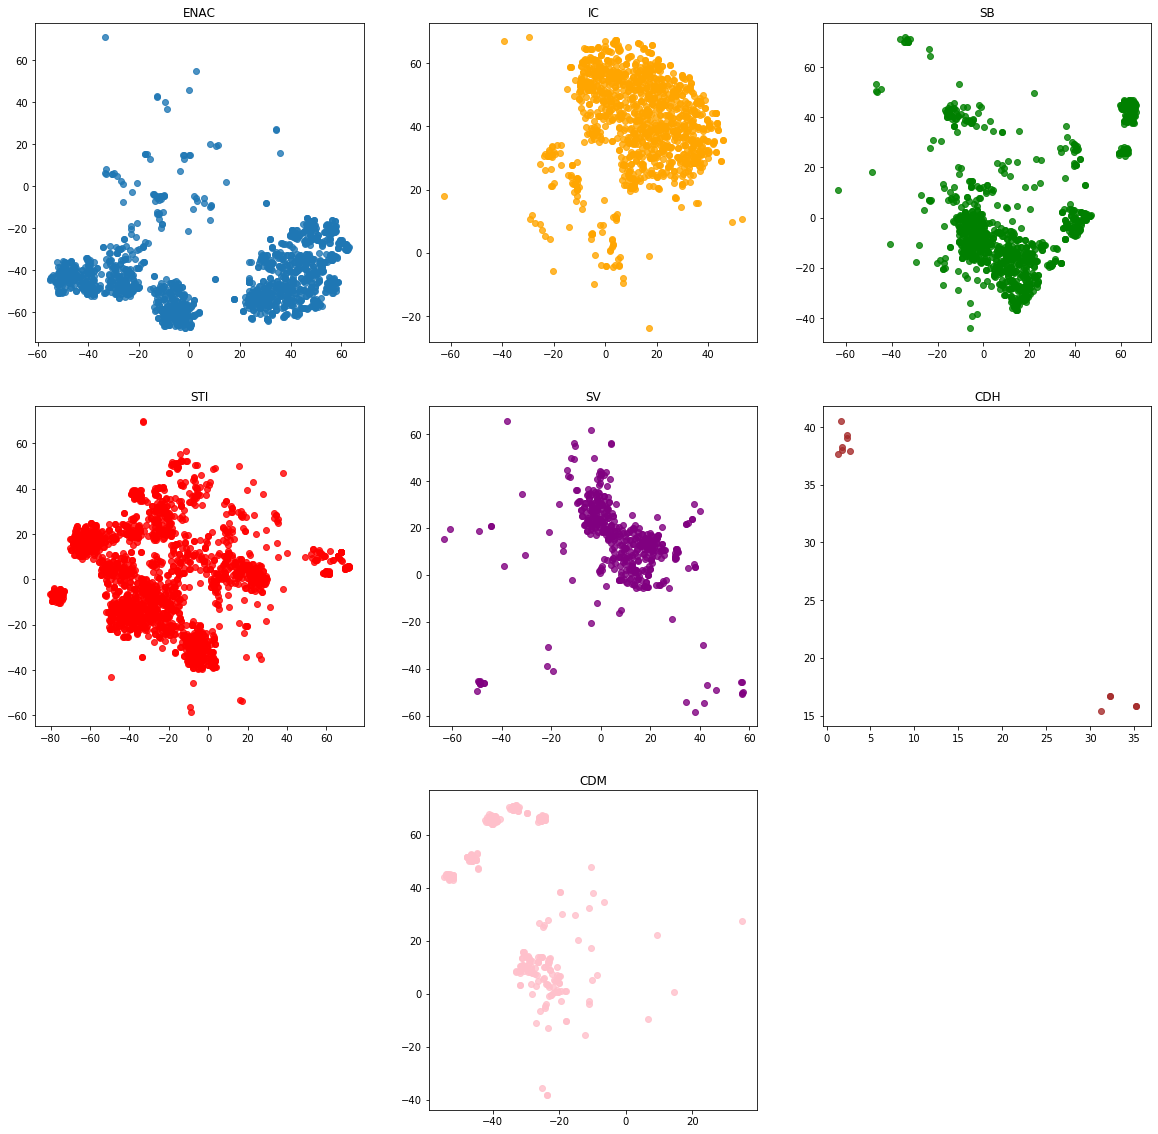

In [16]:
# let us make subplots to see more clearly
fig = plt.figure(figsize=(20,20))

plt.subplot(331)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "ENAC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8)
plt.title("ENAC")

plt.subplot(332)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "IC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "orange")
plt.title("IC")

plt.subplot(333)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "SB"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
plt.title("SB")

plt.subplot(334)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "STI"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "red")
plt.title("STI")

plt.subplot(335)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "SV"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "purple")
plt.title("SV")

plt.subplot(336)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "CDH"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "brown")
plt.title("CDH")

plt.subplot(338)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "CDM"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "pink")
plt.title("CDM")

plt.show()

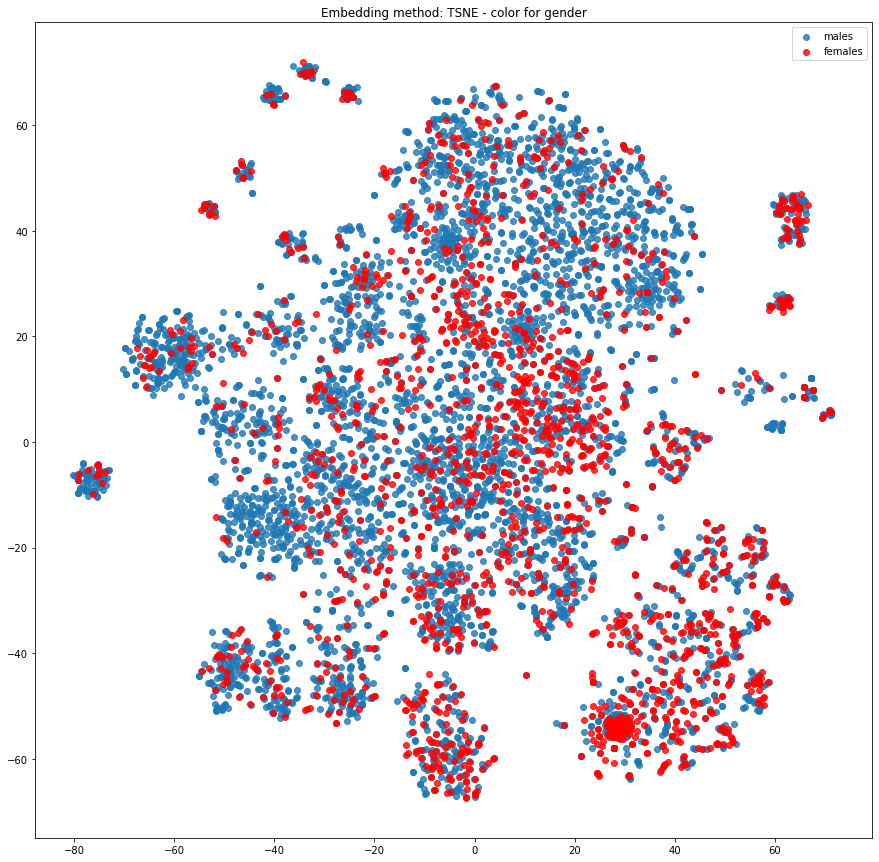

In [17]:
# plot with gender
fig = plt.figure(figsize=(15,15))

males = stu_TSNE_2d[[i for i,gen in enumerate(students_gender) if gen == 1], :]
plt.scatter(males[:,0], males[:,1], label="males", alpha = 0.8)

females = stu_TSNE_2d[[i for i,gen in enumerate(students_gender) if gen == 0], :]
plt.scatter(females[:,0], females[:,1], label="females", alpha = 0.8, color="red")

plt.title('Embedding method: TSNE - color for gender')
plt.legend()
plt.show()

This sight on gender distribution allow us to say one thing : there exists females everywhere in EPFL. We cannot say more yet because this visualization does not represent reality : the size of the dots and their superposition doesn't reflect real amounts of students.

Let us now classify these data in order to define where lies the frontier between males and females and thus being able to predict the gender of a student given the courses he chose.

To do so, we will use support vector machines (SVM), because this is a convex problem and can be solved efficiently.
It is well known that dimentionality augmentation if often used to define this frontier. In our case, we may not need it since we already possess data in high dimention.

Some testing gave us the following conclusion :
Linear SVM on the high dimensional data is not only less good in predicting (its own training data) than SVM on 2D data with RBF kernel, it also cannot be used to predict on other years because courses changes and thus the "course space" is not the same !

That is why we use a SVM with a RBF kernel on the 2D data.

In [18]:
# create SVM
svm_rbf = SVC(kernel = "rbf")

# fit features (dim reduced courses) to labels (gender)
svm_rbf.fit(stu_TSNE_2d, students_gender)

/home/cygnus-x-1/Programmes_installes/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [19]:
# get boundary

x_min = stu_TSNE_2d[:,0].min() - 1
x_max = stu_TSNE_2d[:,0].max() + 1
y_min = stu_TSNE_2d[:,1].min() - 1
y_max = stu_TSNE_2d[:,1].max() + 1

h = 1; # step size in grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

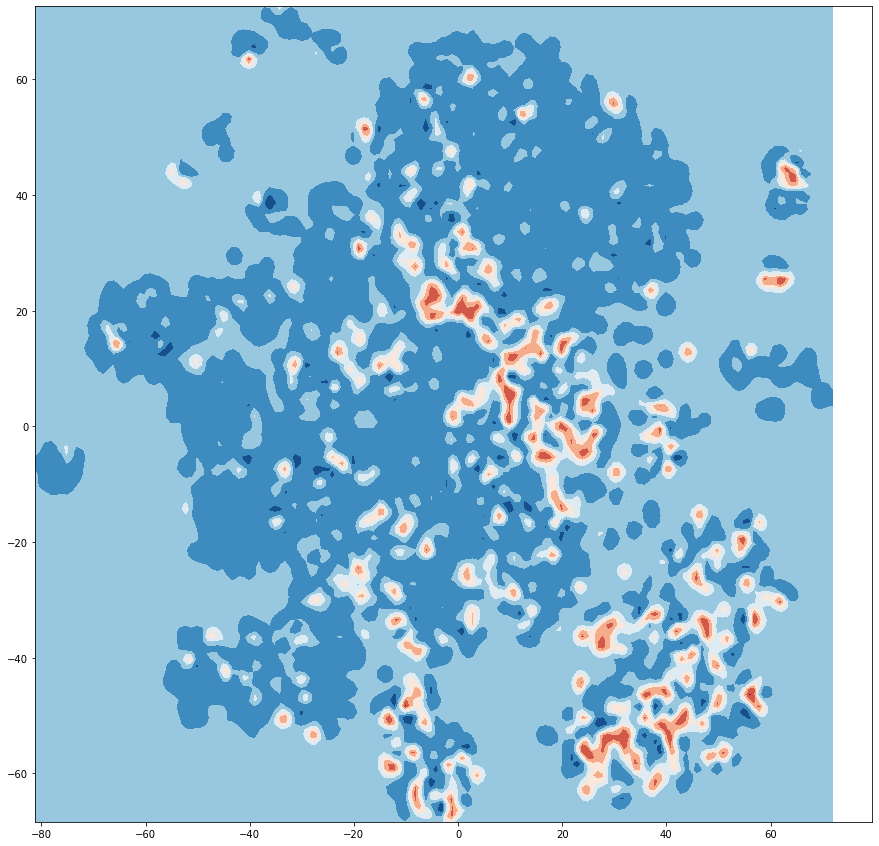

In [20]:
# plot data and boundary
fig, ax = plt.subplots(figsize=(15,15))

plt.scatter(males[:,0], males[:,1], label="males", alpha = 0.1)
plt.scatter(females[:,0], females[:,1], label="females", alpha = 0.1, color="red")
cm = plt.cm.RdBu

ax.contourf(xx, yy, Z, cmap = cm, alpha=1)
plt.show()

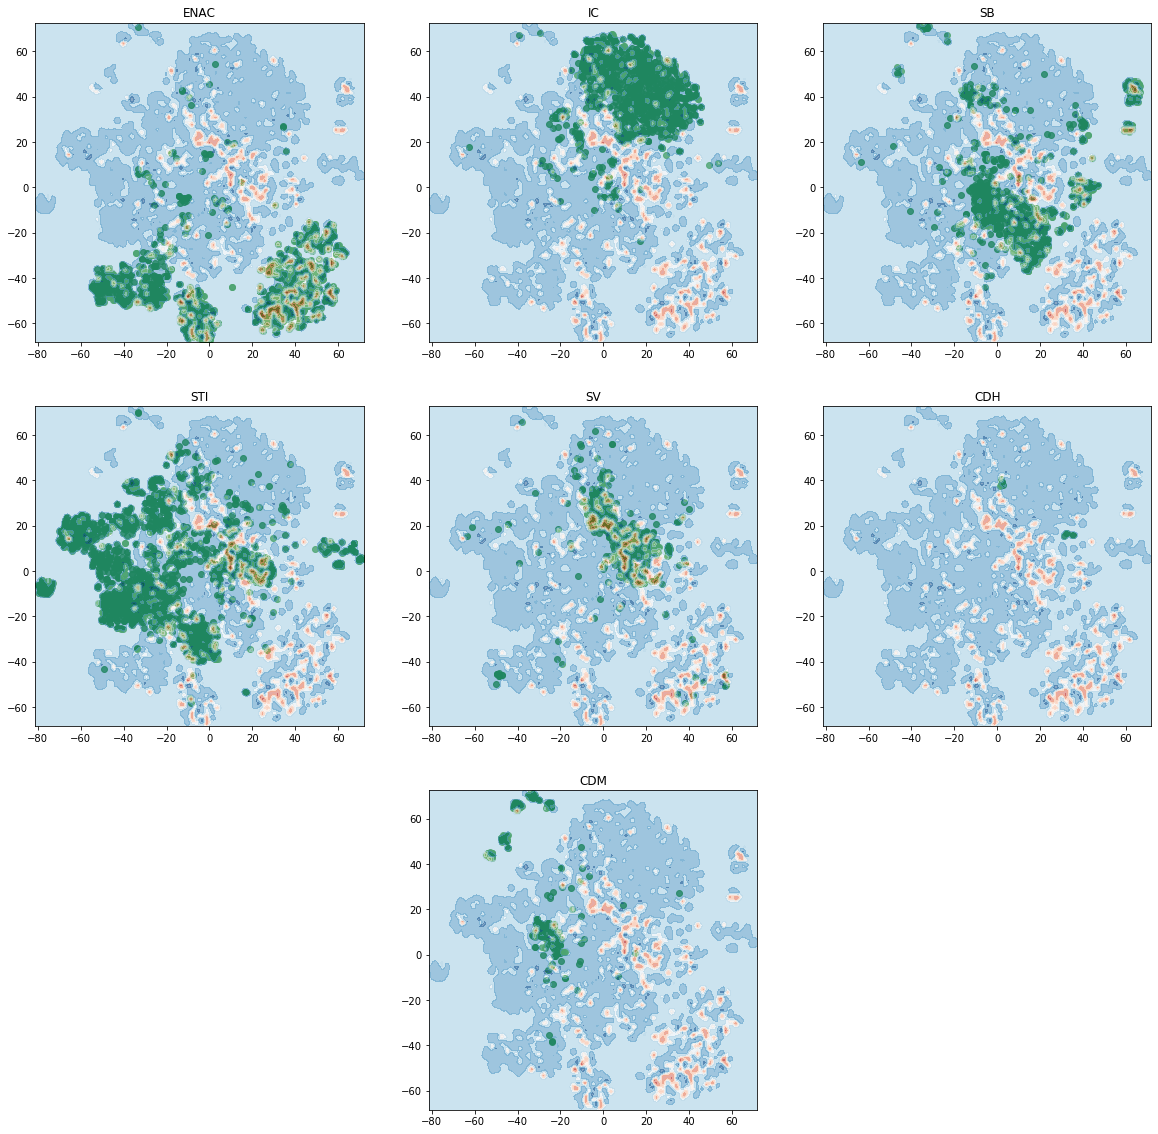

In [21]:
# plot each faculty with the boundaries
fig, ax = plt.subplots(figsize=(20,20))

ax = plt.subplot(331)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "ENAC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("ENAC")

ax = plt.subplot(332)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "IC"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("IC")

ax = plt.subplot(333)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "SB"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("SB")

ax = plt.subplot(334)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "STI"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("STI")

ax = plt.subplot(335)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "SV"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("SV")

ax = plt.subplot(336)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "CDH"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("CDH")

ax = plt.subplot(338)
students_to_plot = stu_TSNE_2d[[i for i,fac in enumerate(students_fac) if fac == "CDM"], :]
plt.scatter(students_to_plot[:,0], students_to_plot[:,1], label=f, alpha = 0.8, color = "green")
ax.contourf(xx, yy, Z, cmap = cm, alpha=.5)
plt.title("CDM")

plt.show()

Visualization through classification is much better : it allow us to see where the amount of females is truely significant. The figure above allow to overlap faculties and the classification and roughly estimate wher emost females are. It shows, without surprize, that many of them are in ENAC and SV faculties which is what we can observe in our everyday life at EPFL. The classification also shows that most of the students are males, since picking a random point in the "2D course space" will most probably end up in the blue region (male).

### 3.2. Graphs creation and visualization

Here we construct two graphs. In both graphs the nodes are represented by student. However:
 - In the first graph (Student-Student Graph), we connect students based on the number of courses they have in common. 
 - As for the second graph (Student-Course Graph), we connect students by the euclidean distance between the data points produced from the dimensionality reduction.

#### Student-Student Graph

For this graph the weight of the edge represent the number of courses two students have in common, computed using the scalar prodcut of the two feature vectors.

In [22]:
A_students = student_course_matrix @ np.transpose(student_course_matrix)
np.fill_diagonal(A_students, 0)
A_students

array([[0., 2., 8., ..., 0., 0., 0.],
       [2., 0., 2., ..., 0., 0., 0.],
       [8., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<function matplotlib.pyplot.show(*args, **kw)>

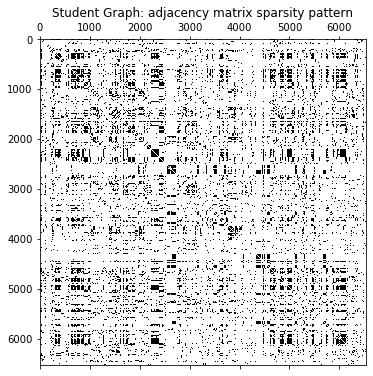

In [23]:
plt.figure(1, figsize=(6, 6))
plt.title('Student Graph: adjacency matrix sparsity pattern')
plt.spy(A_students)
plt.show

In [24]:
num_nodes = A_students.shape[0]
print(f"Number of nodes in the student graph: {num_nodes}")
num_edges = np.count_nonzero(A_students) / 2
print(f"Number of edges in the student graph: {num_edges}")

Number of nodes in the student graph: 6530
Number of edges in the student graph: 2612276.0


In [25]:
max_weight = A_students.max()
print(f"The max number of common courses between two students: {max_weight}")
avg_weight = A_students.mean()
print(f"The avg number of common courses between two students: {avg_weight}")
std_weight = A_students.std()
print(f"The standard diviation: {std_weight}")

The max number of common courses between two students: 24.0
The avg number of common courses between two students: 0.21724916687968593
The standard diviation: 0.7812446109975293


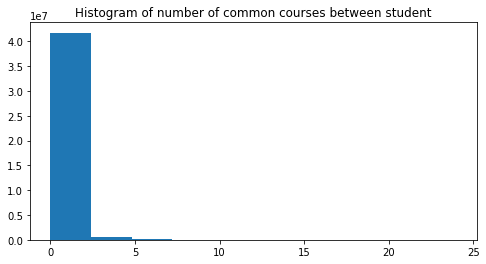

In [26]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of number of common courses between student")
plt.hist(A_students.flatten());

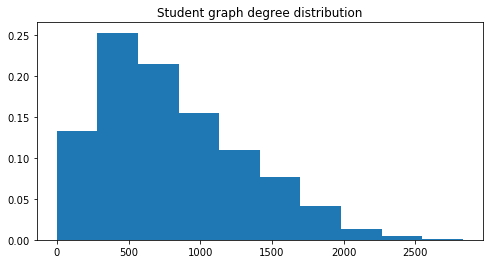

In [27]:
degrees = np.count_nonzero(A_students, axis = 0)

deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

plt.figure(1, figsize=(8, 4))
plt.title('Student graph degree distribution')
plt.hist(degrees, weights=deg_hist_normalization);

Now we sparsify the graph we had:

In [28]:
# used to determine a threshold to sparsify the graph
edges_weights = np.sort((A_students[np.nonzero(A_students)]).flatten())
print(f"The 1st quantile (removing 25% of the edges) is: {np.quantile(edges_weights, 0.25)}")
print(f"The median (removing 50% of the edges) is: {np.quantile(edges_weights, 0.5)}")
print(f"The 3rd quantile (removing 75% of the edges) is: {np.quantile(edges_weights, 0.75)}")

The 1st quantile (removing 25% of the edges) is: 1.0
The median (removing 50% of the edges) is: 1.0
The 3rd quantile (removing 75% of the edges) is: 2.0


In [29]:
threshold = 1

sparsified_A_students = A_students * (A_students > threshold)
sparsified_A_students

array([[0., 2., 8., ..., 0., 0., 0.],
       [2., 0., 2., ..., 0., 0., 0.],
       [8., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

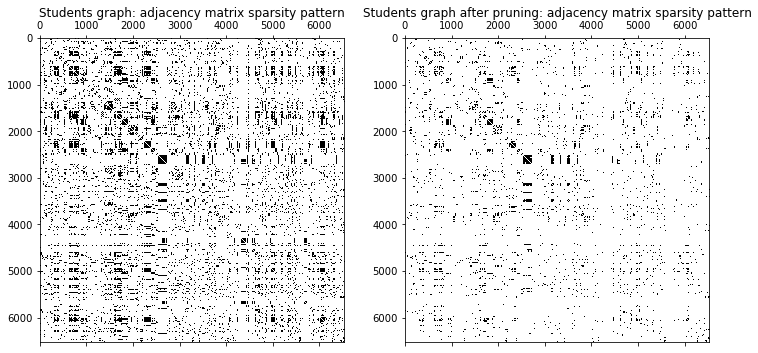

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Students graph: adjacency matrix sparsity pattern')
axes[0].spy(A_students);
axes[1].set_title('Students graph after pruning: adjacency matrix sparsity pattern')
axes[1].spy(sparsified_A_students);

In [31]:
num_edges_pruned = np.count_nonzero(sparsified_A_students) / 2
print(f"Number of edges in the prunned students graph: {num_edges_pruned}")

Number of edges in the prunned students graph: 958353.0


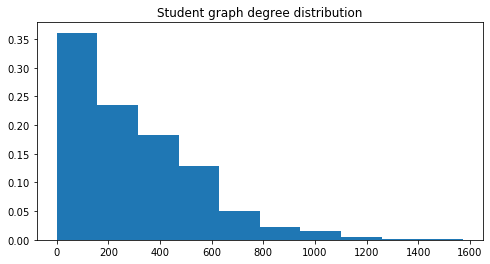

In [32]:
degrees = np.count_nonzero(sparsified_A_students, axis = 0)

deg_hist_normalization = np.ones(degrees.shape[0]) / degrees.shape[0]

plt.figure(1, figsize=(8, 4))
plt.title('Student graph degree distribution')
plt.hist(degrees, weights=deg_hist_normalization);

Now we save the graph for visualization:

In [33]:
G_student = nx.from_numpy_matrix(sparsified_A_students)

# Add node attributes
students_section = []
for row in pd_master["sct_student"]:
    if type(row) is not float:
        students_section.append(row.split(",")[0])
    else:
        students_section.append("other")
students_section = pd.Series(students_section)

nx.set_node_attributes(G_student, pd_master['gender'], 'gender')
nx.set_node_attributes(G_student, students_section, 'section')

In [34]:
nx.write_gexf(G_student, "gephi/student_student_graph.gexf")

## 4. Prediction

### 4.1. Using SVM
In previous sections, we used a SVM in order to classify the students according to their gender. Now that we have this classification, we can use it to predict a student's gender given its course choice. First, we compare two mathods :
* Linear SVM on high dimension data (feature matrix)
* RBF SVM on 2D data
To compare them, we simply test how good the classification is on the training data. It is necessary to keep the same data since other data include different courses and thus changes the high dimension space (as explained in the report).

In [38]:
# create a linear SVM embedding
lin_SVM = LinearSVC()
lin_SVM.fit(student_course_matrix_test, students_gender_test)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [40]:
# test both SVM with their own "training" data
self_score_lin = lin_SVM.score(student_course_matrix_test, students_gender_test)
self_score_rbf = svm_rbf.score(stu_TSNE_2d, students_gender)

print("score of linear SVM in high dimension : " + (str)(self_score_lin))
print("score of RBF kernel SVM in 2D : " + (str)(self_score_rbf))

score of linear SVM in high dimension : 0.8595878449179183
score of RBF kernel SVM in 2D : 0.8241960183767228


We can see that both SVM have a quite close score which means that the resulting classifications fits the data in the same manner. This allow us to assume that both SVM will predict students gender with similar performances. We can therefore use the RBF SVM on 2D to perform prediction.
Let us now do this prediction on students data of 2015 to 2016 :

In [36]:
# apply dimentionality reduction to 2D
test_stu_TSNE_2d = TSNE_embedding.fit_transform(student_course_matrix_test)

In [37]:
# test
test_score = svm_rbf.score(test_stu_TSNE_2d, students_gender_test)
print("score of RBF kernel SVM in 2D on test data is : ", test_score)

score of RBF kernel SVM in 2D on test data is :  0.6978693677960182


This score is not great but not bad either. It is good enogh for a gross approximation.